<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/main/XceptionNaive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import math 
import torch.nn as nn
import torch.nn.functional as f 
import torch.utils.model_zoo as model_zoo
from torch.nn import init 

# Pretrained 된 weight 를 사용할 때 필요합니다. weight 들이 담긴 파일을 다운받는 링크입니다
model_urls = {'xception':'https://www.dropbox.com/s/1hplpzet9d7dv29/xception-c0a72b38.pth.tar?dl=1'}

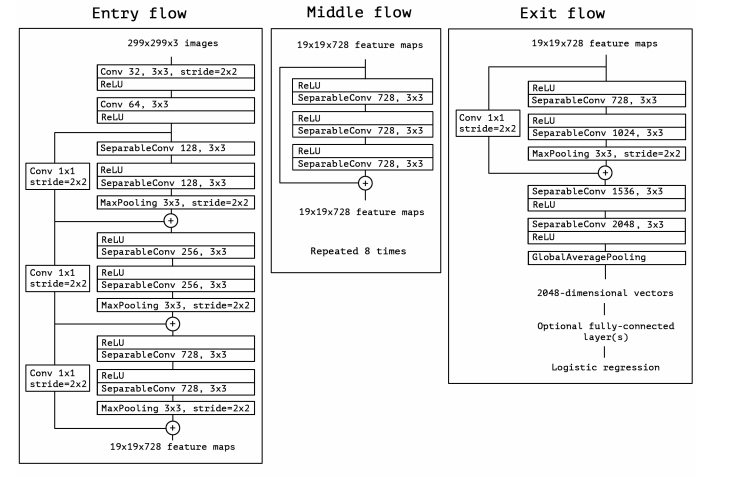

'''
==================================================================
Based on the Xception Paper (https://arxiv.org/pdf/1610.02357.pdf)
==================================================================
REGULARIZATION CONFIGURATION:
- weight_decay: 1e-5
- dropout: no dropout
- aux_loss: no aux loss
OPTIMIZATION CONFIGURATION (for Google JFT Dataset):
- optimizer: RMSProp
- momentum: 0.9
- initial_learning_rate: 0.001
- learning_rate_decay: 0.9 every 3/350 epochs (every 3M images; total 350M images per epoch)
'''

In [2]:
class SeparableConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding =0, dilation=1, bias=False):
    #nn.Module 을 상속받게 만들기 
    super(SeparableConv2d, self).__init__()
    
    #Forward 에서 쓸 함수들을 정의해주기
    self.conv1 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = in_channels, # depthwise convolution 에서는 
                          stride = stride,            # in channel과 out channel의 수가 같다 
                          kernel_size = kernel_size,
                          padding = padding, 
                          dilation = 1, 
                          bias = False, 
                          groups = in_channels #가장 중요한 부분! channel별로 할꺼니까 inchannel 의 개수와 같게! 
                          )
    self.pointwise = nn.Conv2d(in_channels=in_channels, 
                              out_channels = out_channels, 
                              kernel_size = 1, stride = 1, padding=0, dilation=1, groups =1, bias=bias)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.pointwise(x)
    return x 

`SeparableConv2D` 모듈에 해당하는 코드이다. 
`depthwise convolution`은 3x3 연산에 해당하는 것이고 
`pointwise convolution`은 1x1 연산에 해당하는 것

In [4]:
class Block(nn.Module):
    def __init__(self, in_filters, out_filters, reps, 
                 strides=1, start_with_relu=True, grow_first=True):
        super(Block, self).__init__()

      # skip 은 Residual을 가르킨다
      # 인풋과 아웃풋의 필터의 개수가 다르다면 개수를 맞춰주기 위해 depth wise convolution이 각 채널 별로 convolution 연산을 해주기 때문이다. 
      # 필터의 개수가 맞게 convolution 을 진행해야함 -> kernel의 크기는 1로 
        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:       
            self.skip=None    #인풋과 아웃풋 필터의 개수가 같다면 조정할 필요 없음
        
        self.relu = nn.ReLU(inplace=True)
        rep=[] #모든 computation 을 rep 에 저장하기

        filters = in_filters
        if grow_first: #필터의 개수를 늘리고 시작하는 블록이라면
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1): # 블록에 Depthwise convolution이 몇번 있느냐?
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first: # 필터의 개수를 마지막에 늘리는 블록이라면 
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu: #ReLU 로 시작하지 않으면 앞에 ReLU 하나 떼어내가 
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1: # stride 가 1이 아니면 MaxPooling을 적용한다 
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)
        
        #Residual Network의 필터개수 맞춰주기
        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp
        
        #Residual 연결
        x+=skip
        return x

In [5]:
class Xception(nn.Module): 
    def __init__(self, num_classes=1000):
        super(Xception, self).__init__()

        self.num_classes = num_classes
        
        #Entry Flow 에서 쓸 함수 정의하기
        #모든 convolution 다음에는 batch norm이 온다 
        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #ReLU 넣는거 까먹지 않기!

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)
        #Entry Flow 의 아웃풋은 19x 19 x 728 feature maps
        
        # Middle Flow 에서 쓸 함수: 같은거 8번 반복
        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        #Middle Flow 의 아웃풋은 19 x 19 x 728 feature maps-> 크기는 같음

        #Exit Flow 에서 쓸 함수
        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)
        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)
        #ReLU 넣는거 까먹지 않기!

        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)
        #ReLU 넣는거 까먹지 않기!

        #Optional FC Layer 
        self.fc = nn.Linear(2048, num_classes)

        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # Entry Flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        #Middle Flow
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = f.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x